<a href="https://colab.research.google.com/github/A125X/bitcoin-price-prediction/blob/main/art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [169]:
max_trials = 10
epochs = 10

In [170]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout, Activation
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#!pip install keras-tuner
from tensorflow import keras
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import load_model
#!pip install yfinance
import yfinance as yf
from datetime import datetime
import pandas as pd
from numpy import concatenate

In [171]:
#Ensuring the use of gpu tensorflow

if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


2022-12-19 14:07:07.200965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-19 14:07:07.202227: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-19 14:07:07.207544: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-19 14:07:07.207553: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [172]:
#Enter info regarding model

num_inputs=5
look_back = 60
forward_days = 1
num_periods = 20

[*********************100%***********************]  1 of 1 completed


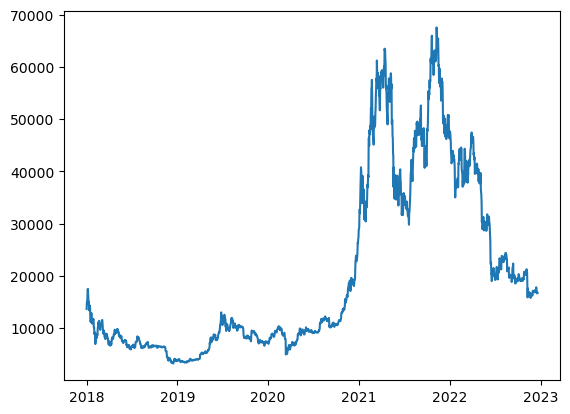

In [173]:
#data

today = datetime.today().strftime('%Y-%m-%d')
idx = pd.date_range('2018-01-01', today)

df_A = yf.download("BTC-USD", start="2018-01-01", end=today)["Close"]
df_A = df_A.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_A)

In [174]:
type(df_A)

pandas.core.series.Series

[*********************100%***********************]  1 of 1 completed


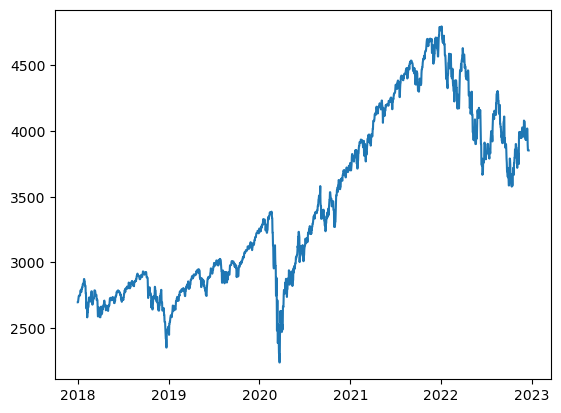

In [175]:
df_B = yf.download("%5EGSPC", start="2018-01-01", end=today)["Close"]
df_B = df_B.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_B)

[*********************100%***********************]  1 of 1 completed


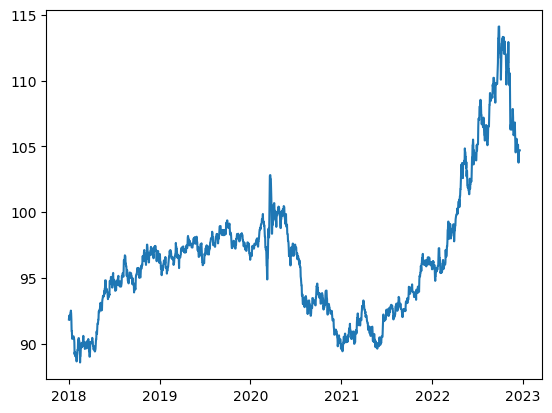

In [176]:
df_C = yf.download("DX-Y.NYB", start="2018-01-01", end=today)["Close"]
df_C = df_C.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_C)

[*********************100%***********************]  1 of 1 completed


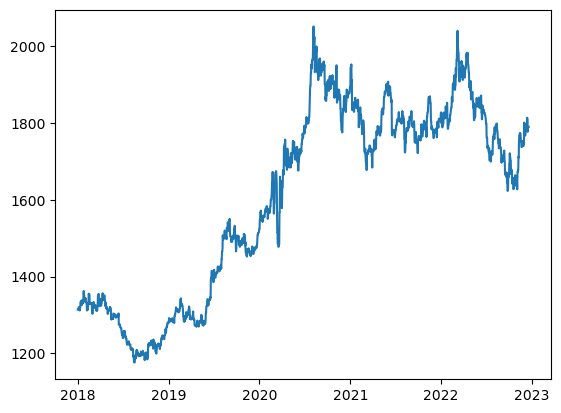

In [177]:
df_D = yf.download("GC=F", start="2018-01-01", end=today)["Close"]
df_D = df_D.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_D)

[*********************100%***********************]  1 of 1 completed


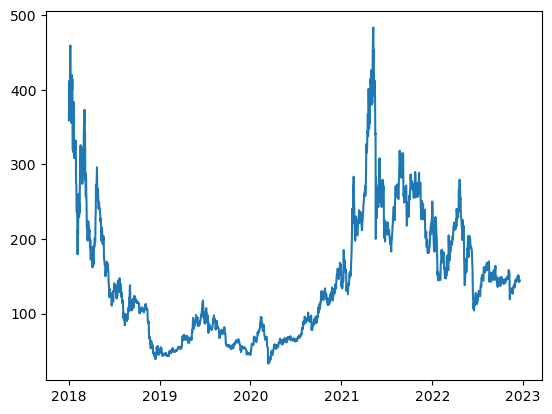

In [178]:
df_E = yf.download("XMR-USD", start="2018-01-01", end=today)["Close"]
df_E = df_E.reindex(idx, fill_value=0, method="nearest")

plt.plot(df_E)

In [179]:
timeseries = pd.concat([df_A, df_B, df_C, df_D, df_E], axis=1)

timeseries.columns=(["Close-btc", "Close-sp500", "Close-dxy", "Close-gold", "Close-xmr"])
timeseries

,Close-btc,Close-sp500,Close-dxy,Close-gold,Close-xmr
2018-01-01,13657.200195,2695.810059,91.849998,1313.699951,358.989990
2018-01-02,14982.099609,2695.810059,91.849998,1313.699951,383.416992
2018-01-03,15201.000000,2713.060059,92.160004,1316.199951,412.062988
2018-01-04,15599.200195,2723.989990,91.849998,1319.400024,403.048004
2018-01-05,17429.500000,2743.149902,91.949997,1320.300049,384.936005
...,...,...,...,...,...
2022-12-15,17364.865234,3895.750000,104.559998,1777.199951,149.065460
2022-12-16,16647.484375,3852.360107,104.699997,1790.000000,142.141907
2022-12-17,16795.091797,3852.360107,104.699997,1790.000000,143.448380
2022-12-18,16757.976562,3852.360107,104.699997,1790.000000,144.340393


In [180]:
scaler = MinMaxScaler()

timeseries[
    ["Close-btc", "Close-sp500", "Close-dxy", "Close-gold", "Close-xmr"]
    ] = scaler.fit_transform(timeseries[
        ["Close-btc", "Close-sp500", "Close-dxy", "Close-gold", "Close-xmr"]
        ])

timeseries["Close-btc-output"] = timeseries["Close-btc"].shift(-1)
timeseries.drop(timeseries.tail(1).index, inplace=True)

array = timeseries.values

timeseries.head()

,Close-btc,Close-sp500,Close-dxy,Close-gold,Close-xmr,Close-btc-output
2018-01-01,0.161984,0.179125,0.127743,0.157089,0.723478,0.182579
2018-01-02,0.182579,0.179125,0.127743,0.157089,0.777691,0.185982
2018-01-03,0.185982,0.185866,0.139891,0.159945,0.841267,0.192172
2018-01-04,0.192172,0.190137,0.127743,0.163601,0.821260,0.220624
2018-01-05,0.220624,0.197623,0.131661,0.164629,0.781062,0.222139


In [182]:
array[:5]

array([[0.16198395, 0.17912523, 0.12774301, 0.15708899, 0.72347756,
        0.18257929],
       [0.18257929, 0.17912523, 0.12774301, 0.15708899, 0.77769072,
        0.18598206],
       [0.18598206, 0.18586572, 0.13989055, 0.15994515, 0.84126749,
        0.19217201],
       [0.19217201, 0.19013663, 0.12774301, 0.16360113, 0.82125968,
        0.22062372],
       [0.22062372, 0.19762343, 0.13166144, 0.16462937, 0.78106201,
        0.22213934]])

In [ ]:
#split in Train and Test
division = len(array) - num_periods*forward_days

array_test = array[division:]
array_train = array[:division]
# split into input and outputs
X_train, Y_train = array_train[:, :-1], array_train[:, -1]
X_test, Y_test = array_test[:, :-1], array_test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train, X_validate, Y_train, Y_validate = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

In [ ]:
#Training the model

class MyHyperModel(HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        '''
        # Specify model
        model = Sequential()
        NUM_NEURONS_FirstLayer = hp.Choice('NUM_NEURONS_FirstLayer',values=[80, 90, 100, 120])

        model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))

        model.add(Dropout(hp.Float('dropout_1', 0, 0.4, step=0.1, default=0)))

        
        NUM_NEURONS_SecondLayer = hp.Choice('NUM_NEURONS_SecondLayer',values=[30, 40, 50, 60, 70])
        model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))

        model.add(Dropout(hp.Float('dropout_2', 0, 0.4, step=0.1, default=0)))

        # Output layer
        model.add(Dense(forward_days, activation='linear'))

        # Compile the constructed model and return it
        model.compile(
            optimizer=Adam(
                hp.Choice('learning_rate',
                          values=[0.01, 0.001, 0.0001])),
            loss='mean_squared_error')

        '''
        model = keras.Sequential()
        model.add(keras.layers.Dense(
            hp.Choice('units', [8, 16, 32]),
            activation='relu'))
        model.add(keras.layers.Dense(1, activation='relu'))
        model.compile(loss='mse')
        
        return model

hypermodel = MyHyperModel(num_classes=1)    

In [ ]:
# Construct the RandomSearch tuner
random_tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=max_trials,
    executions_per_trial = 1,
    seed=10, 
    project_name='lstm-kerastuner-multi',
    directory="models-temp")

# Search for the best parameters of the neural network using the contructed random search tuner
random_tuner.search(X_train, Y_train,
             epochs=epochs,
             validation_data=(X_validate, Y_validate))

INFO:tensorflow:Reloading Oracle from existing project models-temp/lstm-kerastuner-multi/oracle.json
INFO:tensorflow:Reloading Tuner from models-temp/lstm-kerastuner-multi/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [ ]:
#get the best model

random_params = random_tuner.get_best_hyperparameters()[0]
best_model = random_tuner.get_best_models(1)[0]

In [ ]:
#Evaluate it on the validation test

print("Evalutation of best performing model:")
print(best_model.evaluate(X_validate, Y_validate))

Evalutation of best performing model:
 5/12 [===========>..................] - ETA: 0s - loss: 0.1121

2022-12-18 23:33:38.730422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 15ms/step - loss: 0.1316
0.13163989782333374


In [ ]:
#Get summary

random_tuner.results_summary()

Results summary
Results in models-temp/lstm-kerastuner-multi
Showing 10 best trials
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 120
dropout_1: 0.1
NUM_NEURONS_SecondLayer: 50
dropout_2: 0.2
learning_rate: 0.01
units: 8
Score: 0.00019056345627177507
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 100
dropout_1: 0.1
NUM_NEURONS_SecondLayer: 70
dropout_2: 0.30000000000000004
learning_rate: 0.01
Score: 0.00019480742048472166
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 80
dropout_1: 0.2
NUM_NEURONS_SecondLayer: 60
dropout_2: 0.1
learning_rate: 0.01
Score: 0.00019669815083034337
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 100
dropout_1: 0.4
NUM_NEURONS_SecondLayer: 50
dropout_2: 0.2
learning_rate: 0.01
Score: 0.00019710976630449295
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 80
dropout_1: 0.4
NUM_NEURONS_SecondLayer: 30
dropout_2: 0.2
learning_rate: 0.01
Score: 0.0002051455230684951
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 120


In [ ]:
#Saving the model

file_name = 'LSTM_BTC_tuned_multi.h5'
best_model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `LSTM_BTC_tuned_multi.h5` to disk


In [ ]:
#Predict 

yhat = best_model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

inv_yhat = concatenate((yhat, X_test[:,1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

Y_test = Y_test.reshape((len(Y_test)), 1)
inv_y = concatenate((Y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

plt.figure(figsize = (15,10))
plt.plot(inv_yhat, color='r', label='Prediction') 
plt.plot(inv_y, label='Target')
plt.xticks(np.arange(0, 20, 1), np.arange(1, 21, 1))
plt.xlabel('Days')
plt.ylabel('USD')
plt.legend(loc='best')
plt.show()

1/1 [==============================] - 0s 91ms/step


2022-12-18 23:33:39.136438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)